# χpods: EQUIX vs TAO

In [44]:
import cf_xarray
import dcpy
import eddydiff

import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pump
import xarray as xr
import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.style.use("bmh")
plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200

In [2]:
eop = xr.open_dataset(
    "/home/deepak/datasets/microstructure/osu/equix/hourly_eop.nc"
).rename({"dTdz": "Tz"})
eop["salt"] = 35 * xr.ones_like(eop.theta)
eop["salt"].attrs = {"standard_name": "sea_water_salinity"}
eop["T"] = dcpy.eos.temp(eop.salt, eop.theta, eop.depth)
eop.coords["pres"] = dcpy.eos.pres(eop.depth, 0)
eop.coords["latitude"] = 0
eop.coords["longitude"] = -140
# eop["gamma_n"] = dcpy.oceans.neutral_density(eop)
# eop["pden"] = dcpy.eos.pden(eop.salt, eop.theta, 0)
eop.attrs["name"] = "EQUIX"

In [4]:
tao = xr.open_dataset("/home/deepak/datasets/microstructure/osu/equix/hourly_tao.nc")
tao.attrs["name"] = "TAO"
tao_eop = dcpy.util.slice_like(tao, eop.time).drop_sel(depth=[39, 84])
tao_eop

<xarray.Dataset>
Dimensions:  (depth: 5, time: 2692)
Coordinates:
  * time     (time) datetime64[ns] 2008-11-11T05:00:00 ... 2009-03-03T08:00:00
  * depth    (depth) int64 18 59 69 124 150
    unit     (depth) int64 ...
Data variables:
    theta    (time, depth) float64 ...
    chi      (time, depth) float64 ...
    eps      (time, depth) float64 ...
    Kt       (time, depth) float64 ...
    Jq       (time, depth) float64 ...
    dTdz     (time, depth) float64 ...
Attributes:
    name:     TAO

## χ, ε distributions

TAO 59m looks weird

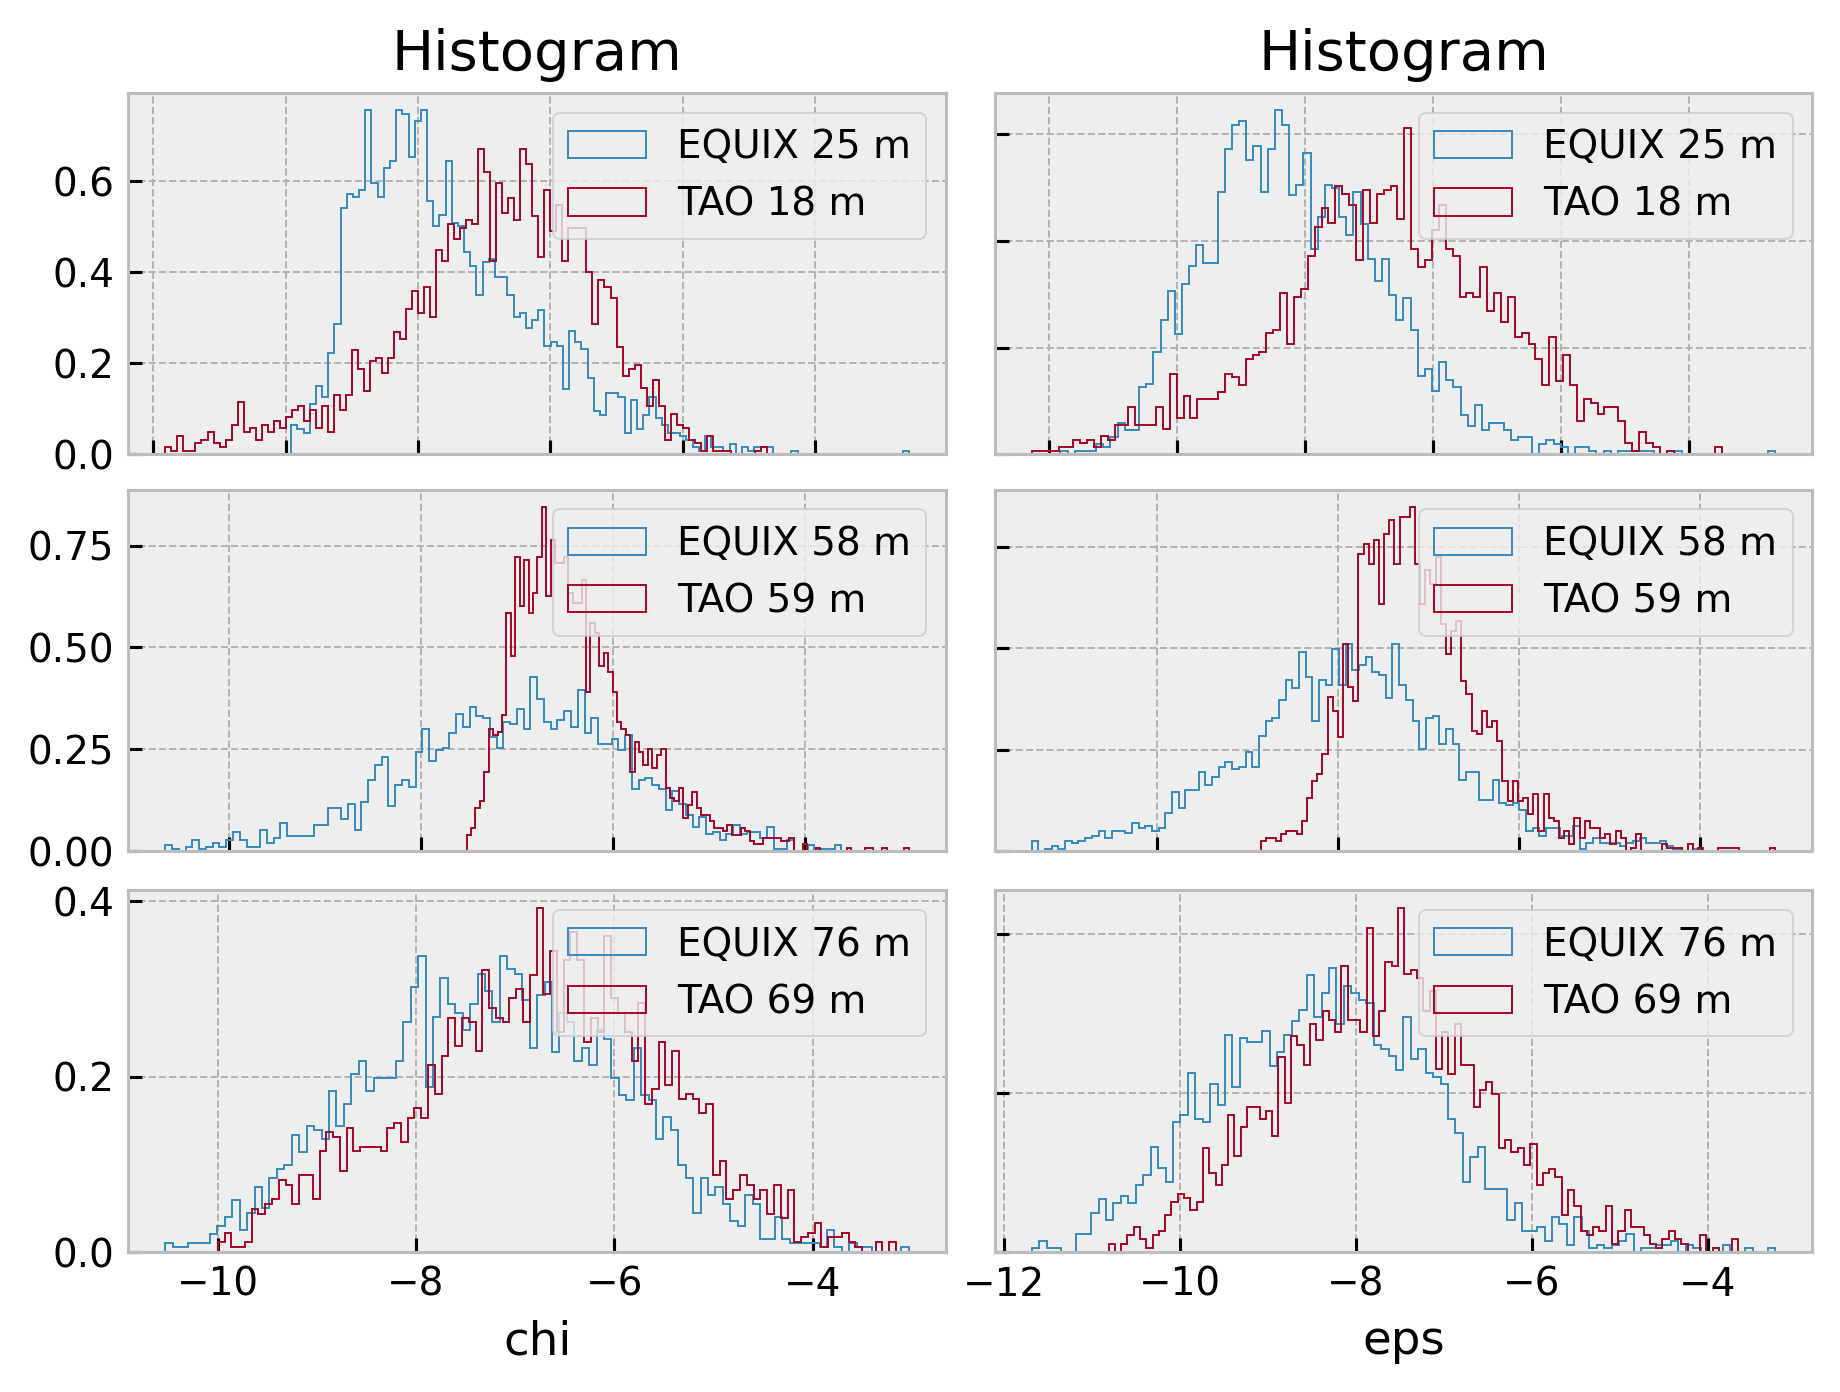

In [36]:
fg = dcpy.facetgrid.facetgrid([0, 1, 2], ["chi", "eps"], sharex=False, sharey=False)

for ds in [eop.sel(depth=[25, 58, 76]), tao_eop.sel(depth=[18, 59, 69])]:
    for idx, _ in enumerate(ds.depth):
        for var in fg.col_locs:
            np.log10(ds[var].isel(depth=idx)).plot.hist(
                ax=fg.axes_dict[idx][var],
                bins=100,
                histtype="step",
                label=f"{ds.attrs['name']} {ds.depth[idx].values} m",
                density=True
            )
for ax in fg.axes.flat:
    ax.legend()

dcpy.plots.clean_axes(fg.axes)

## Time series

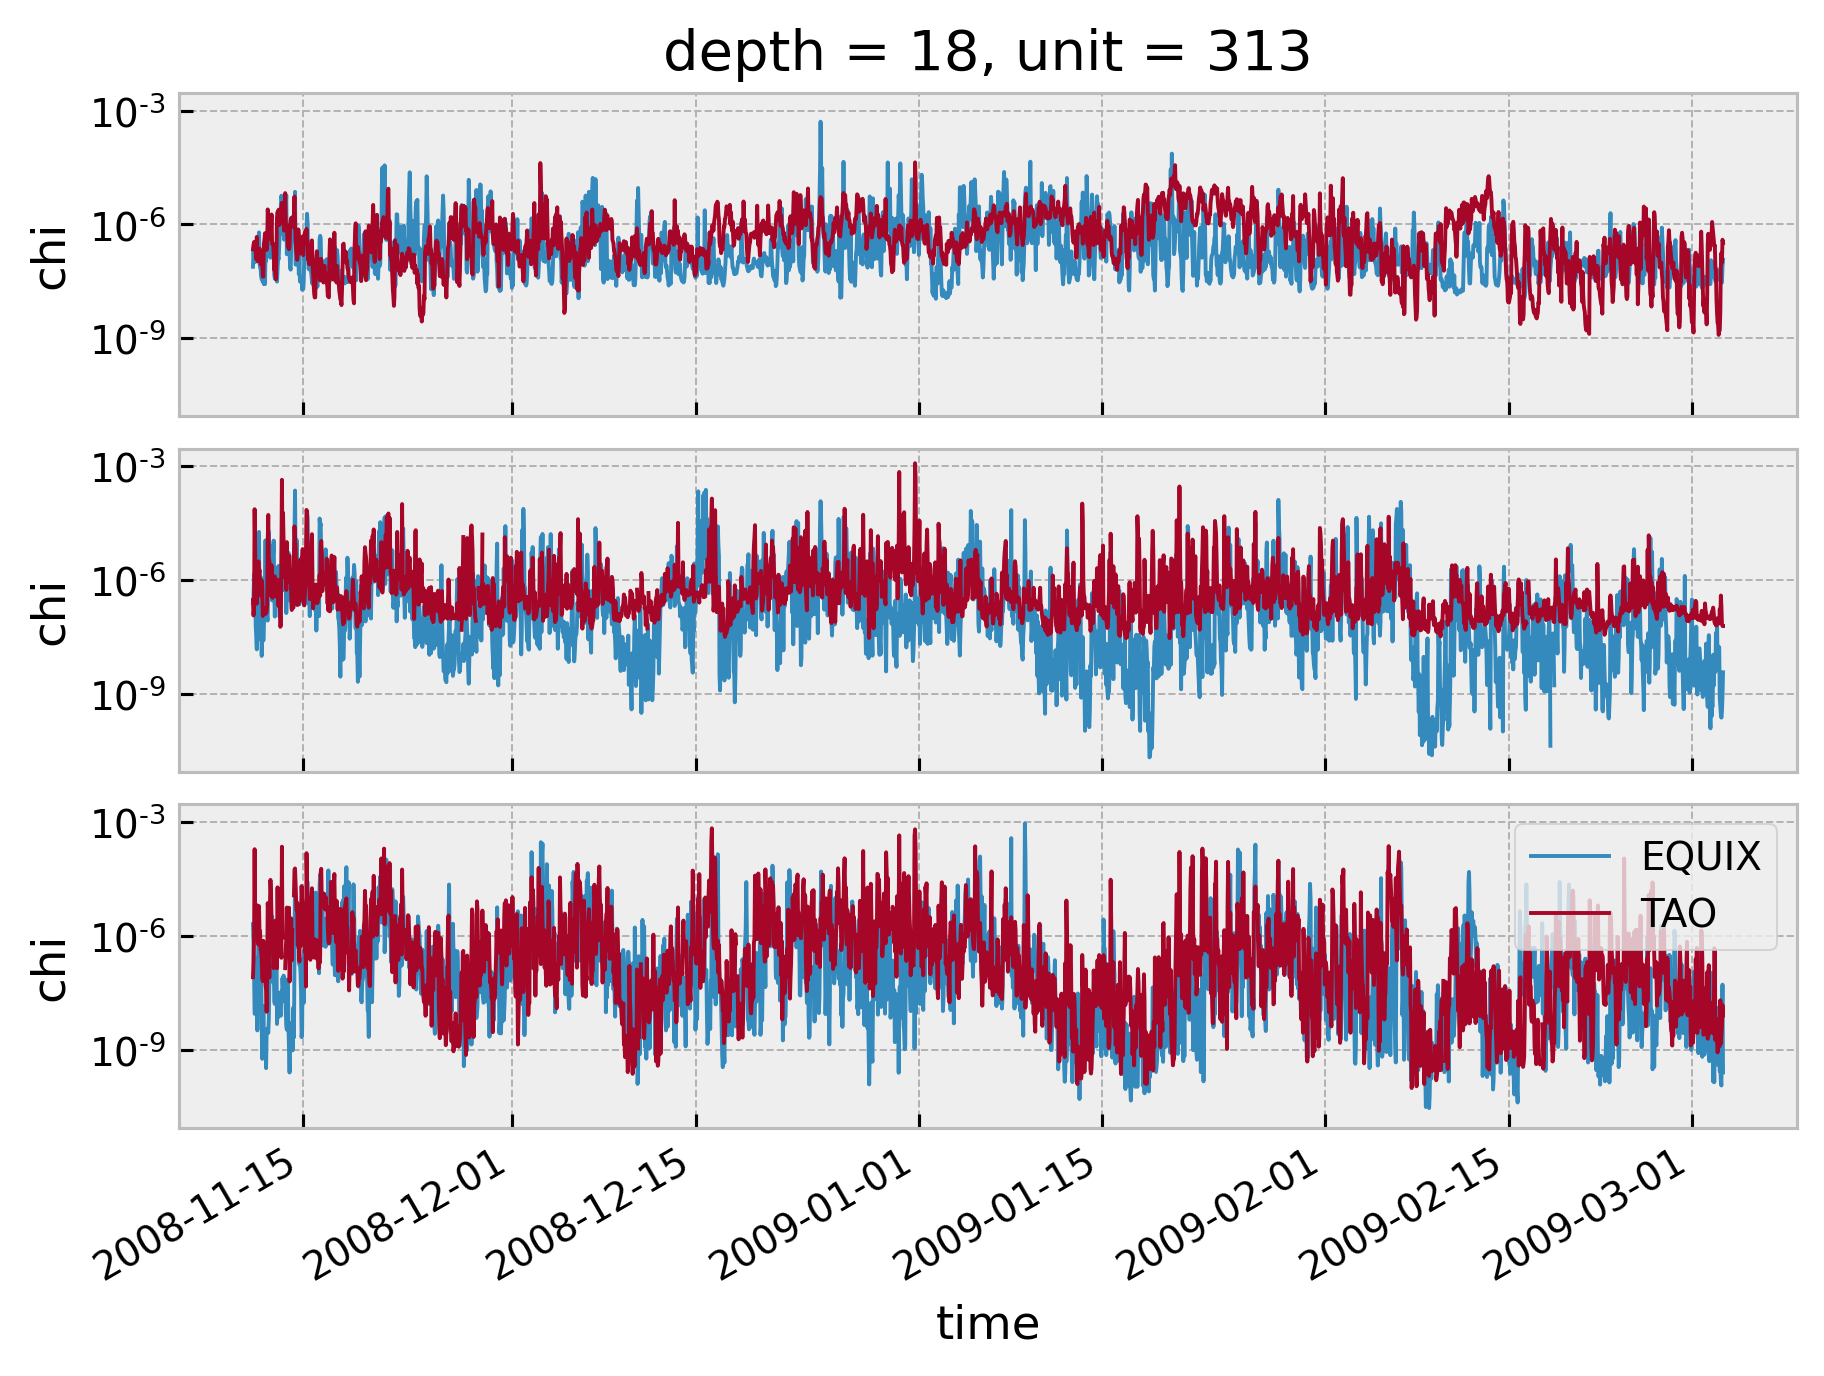

In [48]:
f, ax = plt.subplots(3, 1, squeeze=False, sharex=True, sharey=True, constrained_layout=True)
for axis, depth in zip(ax.flat, [25, 58, 75]):
    kwargs = dict(yscale="log", x="time", lw=1, ax=axis)
    eop.sel(depth=depth, method="nearest").chi.plot(**kwargs)
    tao_eop.sel(depth=depth, method="nearest").chi.plot(**kwargs)
plt.legend(["EQUIX", "TAO"])
dcpy.plots.clean_axes(ax)

## Time means

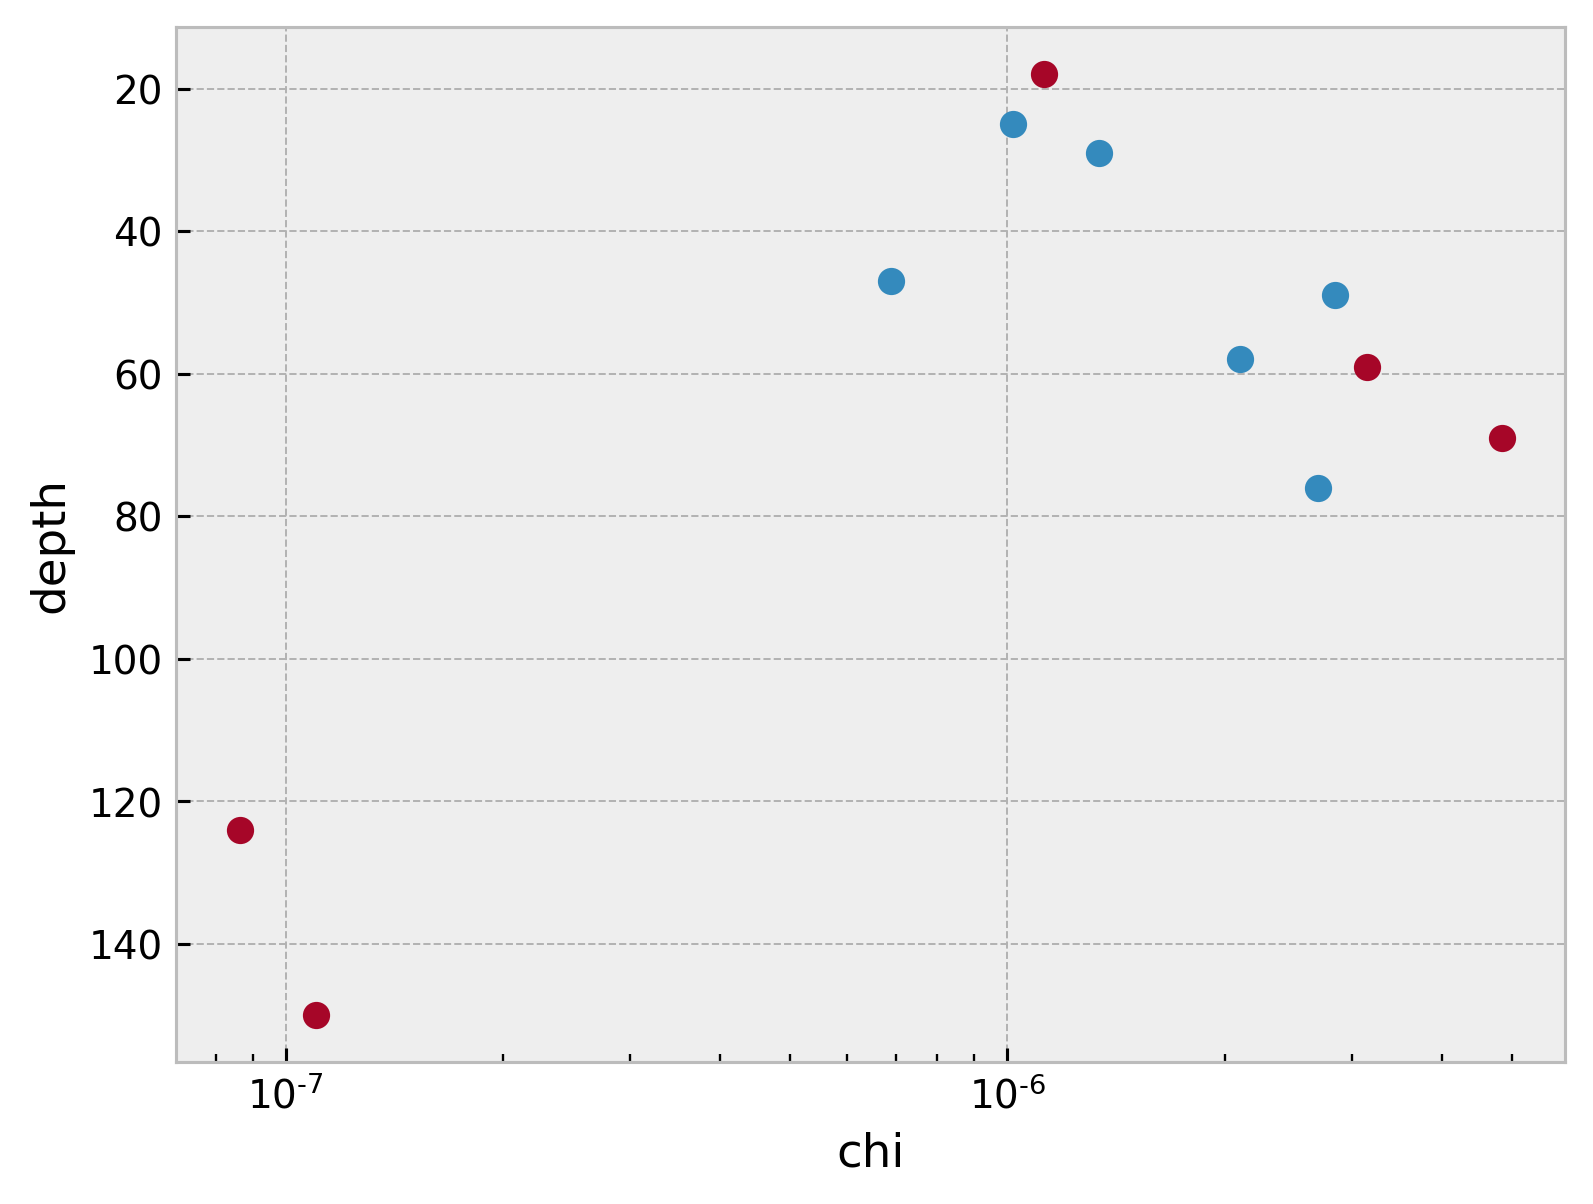

In [55]:
kwargs = dict(xscale="log", marker='o', ls="none", y="depth")
eop.chi.mean("time").cf.plot(**kwargs)
tao_eop.chi.mean("time").cf.plot(**kwargs)

Compared with the surrounding points, it looks like EQUIX 47m is too low? Here's a 12H average of 47m, 49m

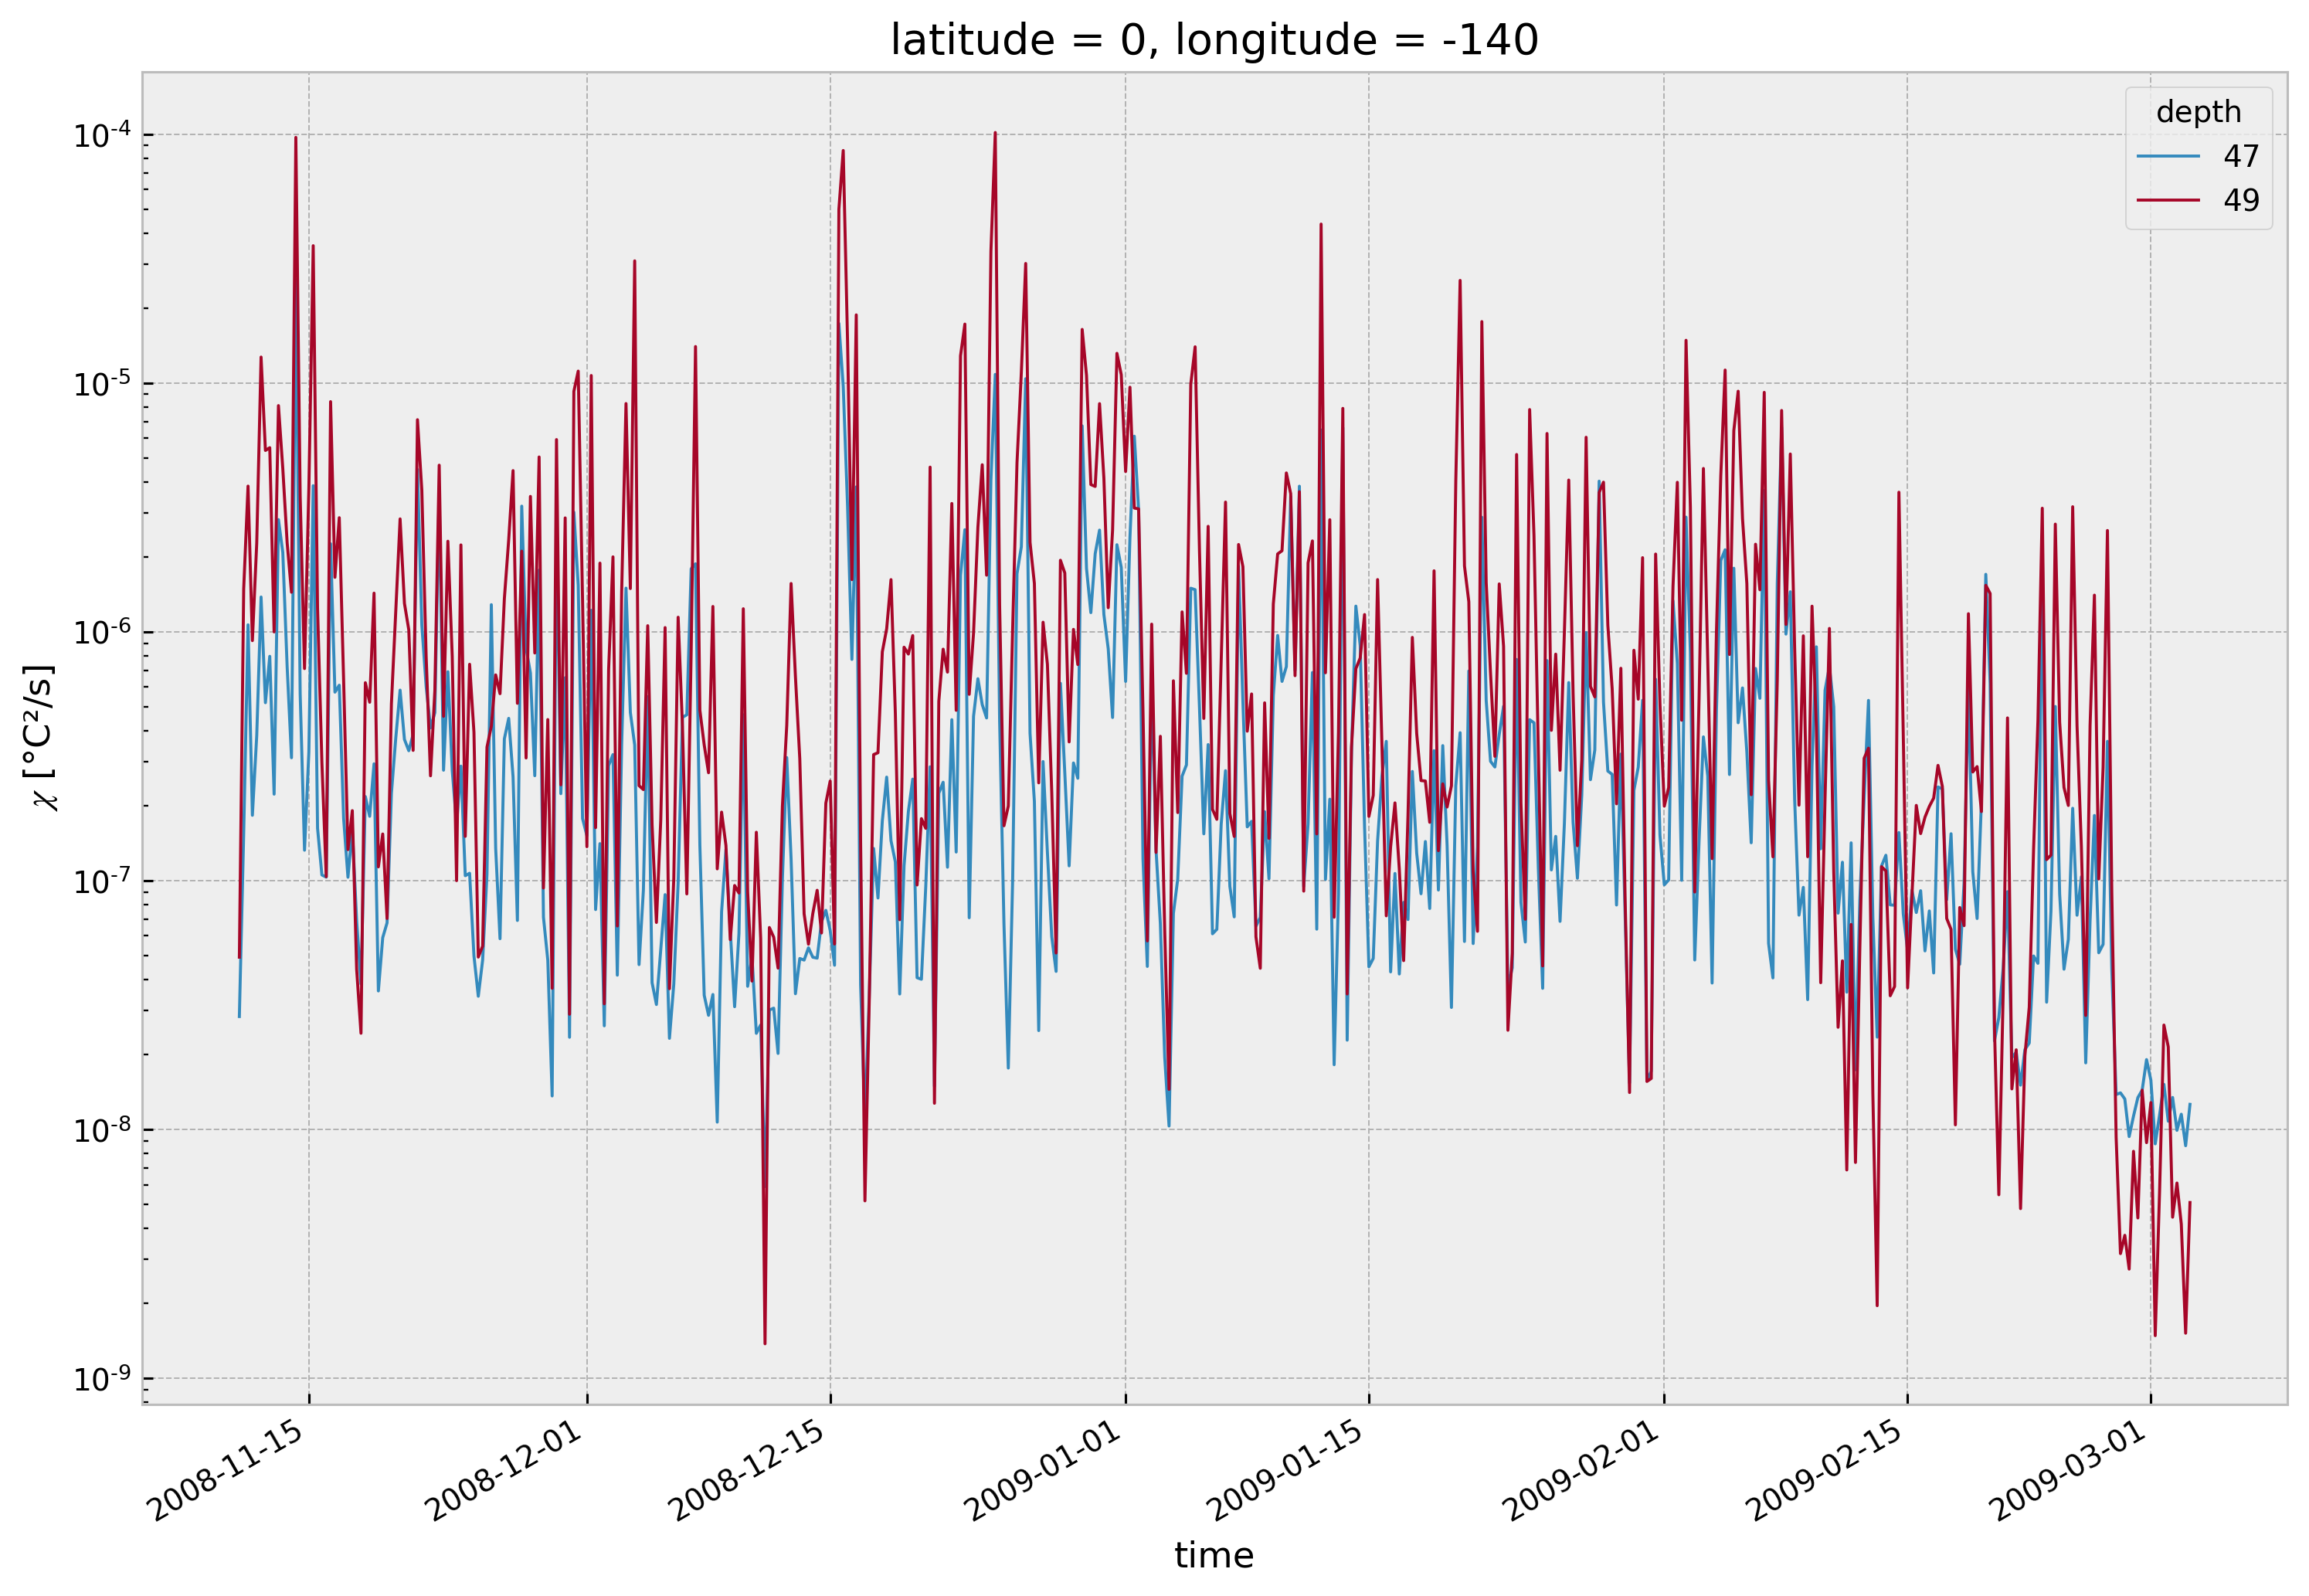

In [66]:
eop.chi.sel(depth=[47, 49]).resample(time="6H").mean().plot.line(
    hue="depth", yscale="log", lw=1, size=8, aspect=1.6
)

## pcolor plots

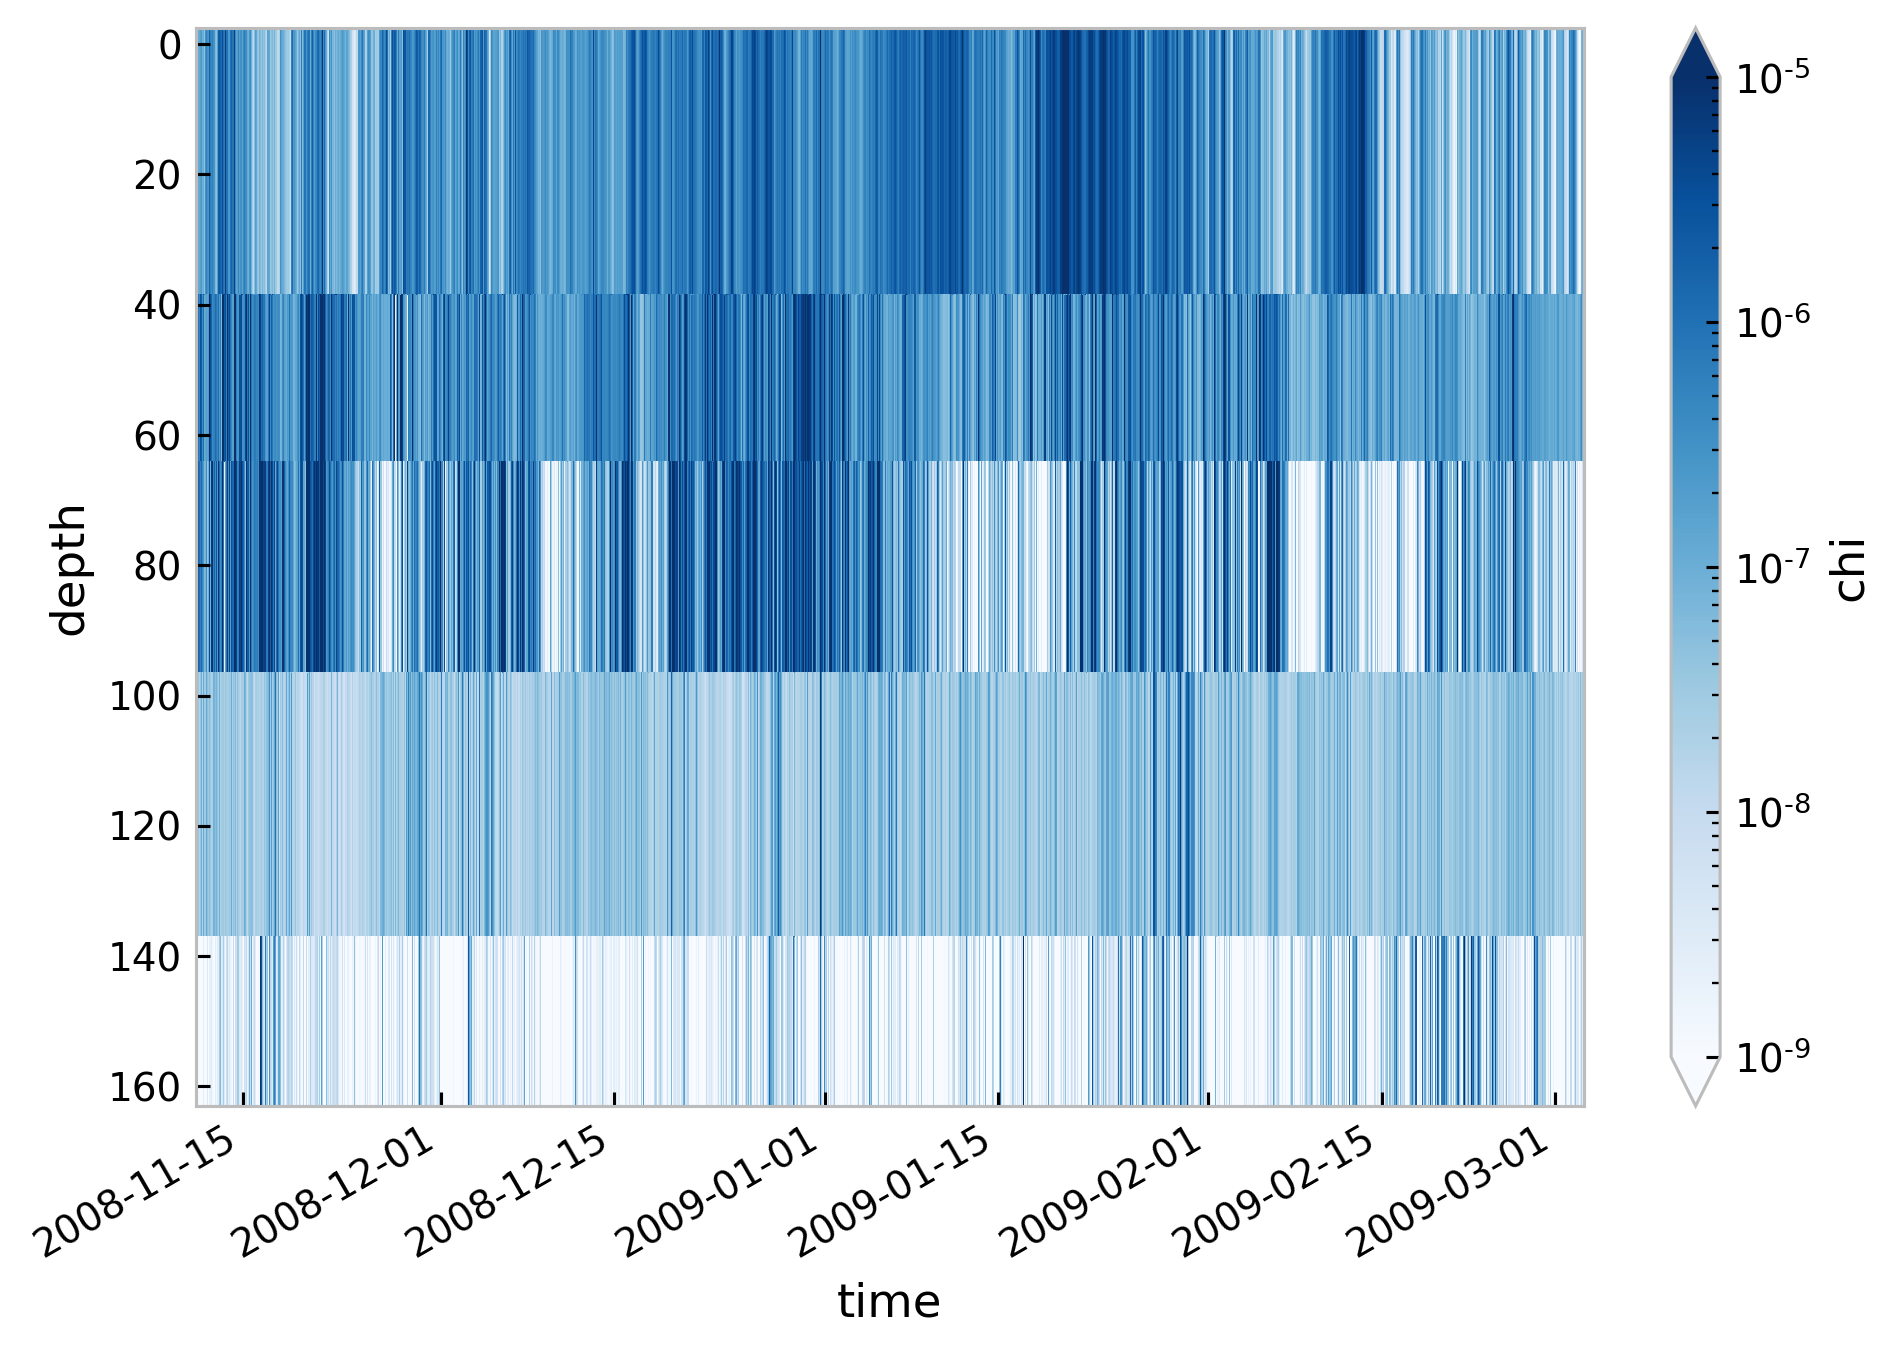

In [47]:
tao_eop.chi.cf.plot(robust=True, norm=mpl.colors.LogNorm(1e-9, 1e-5), cmap=mpl.cm.Blues)

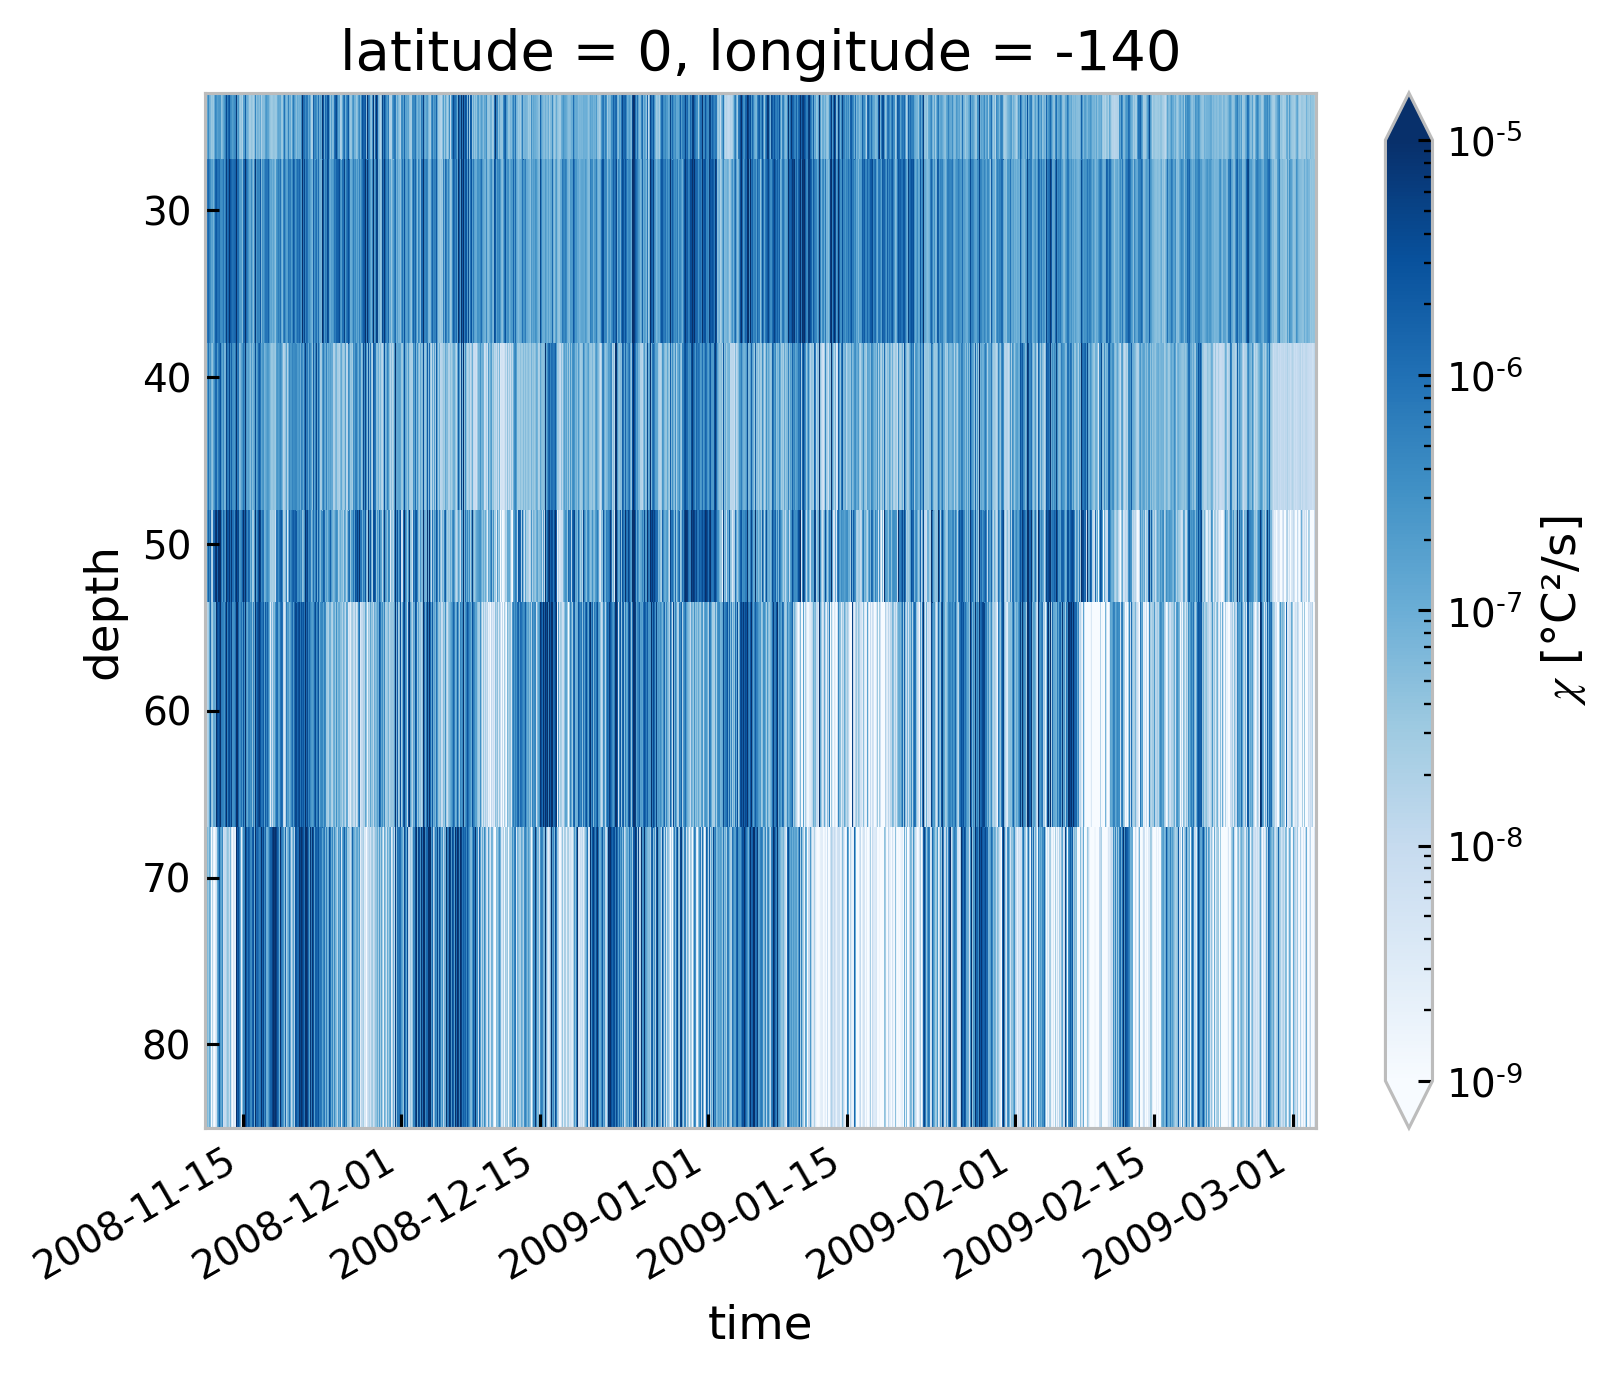

In [42]:
eop.chi.cf.plot(robust=True, norm=mpl.colors.LogNorm(1e-9, 1e-5), cmap=mpl.cm.Blues)

### TAO Data availability

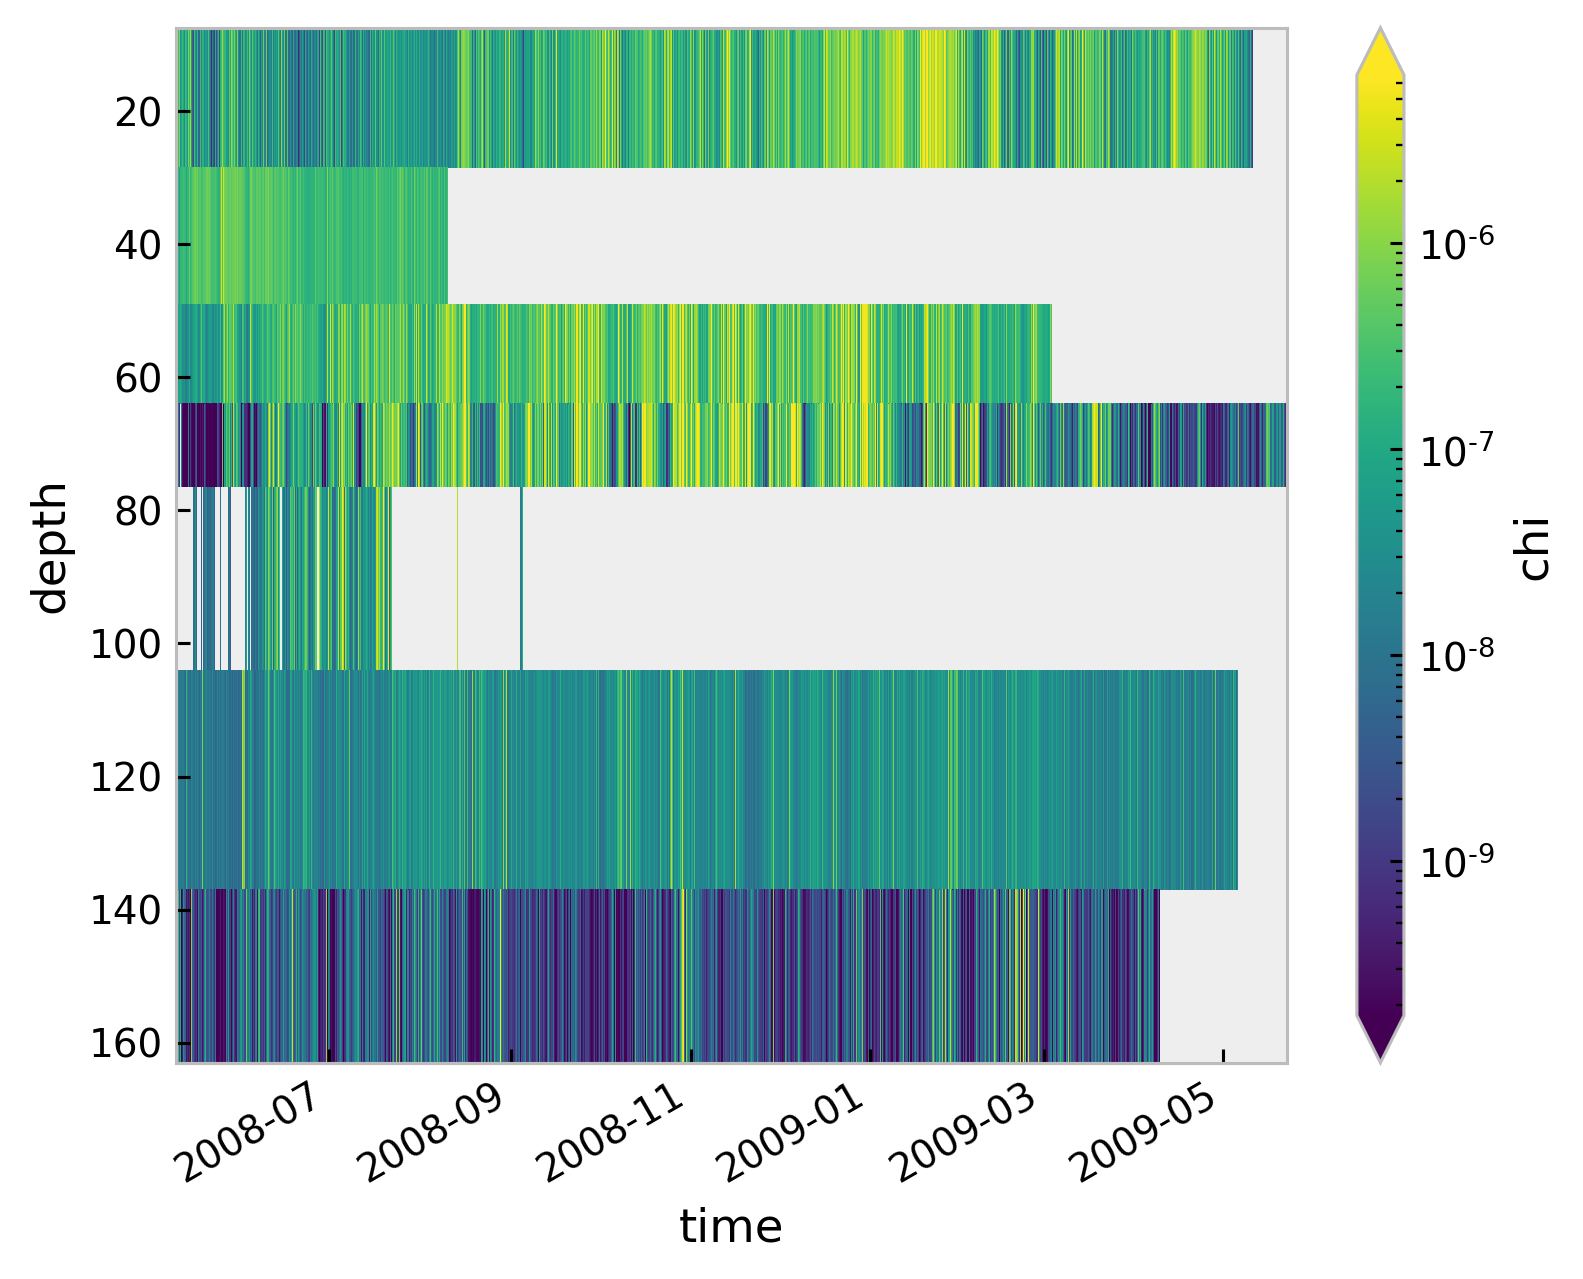

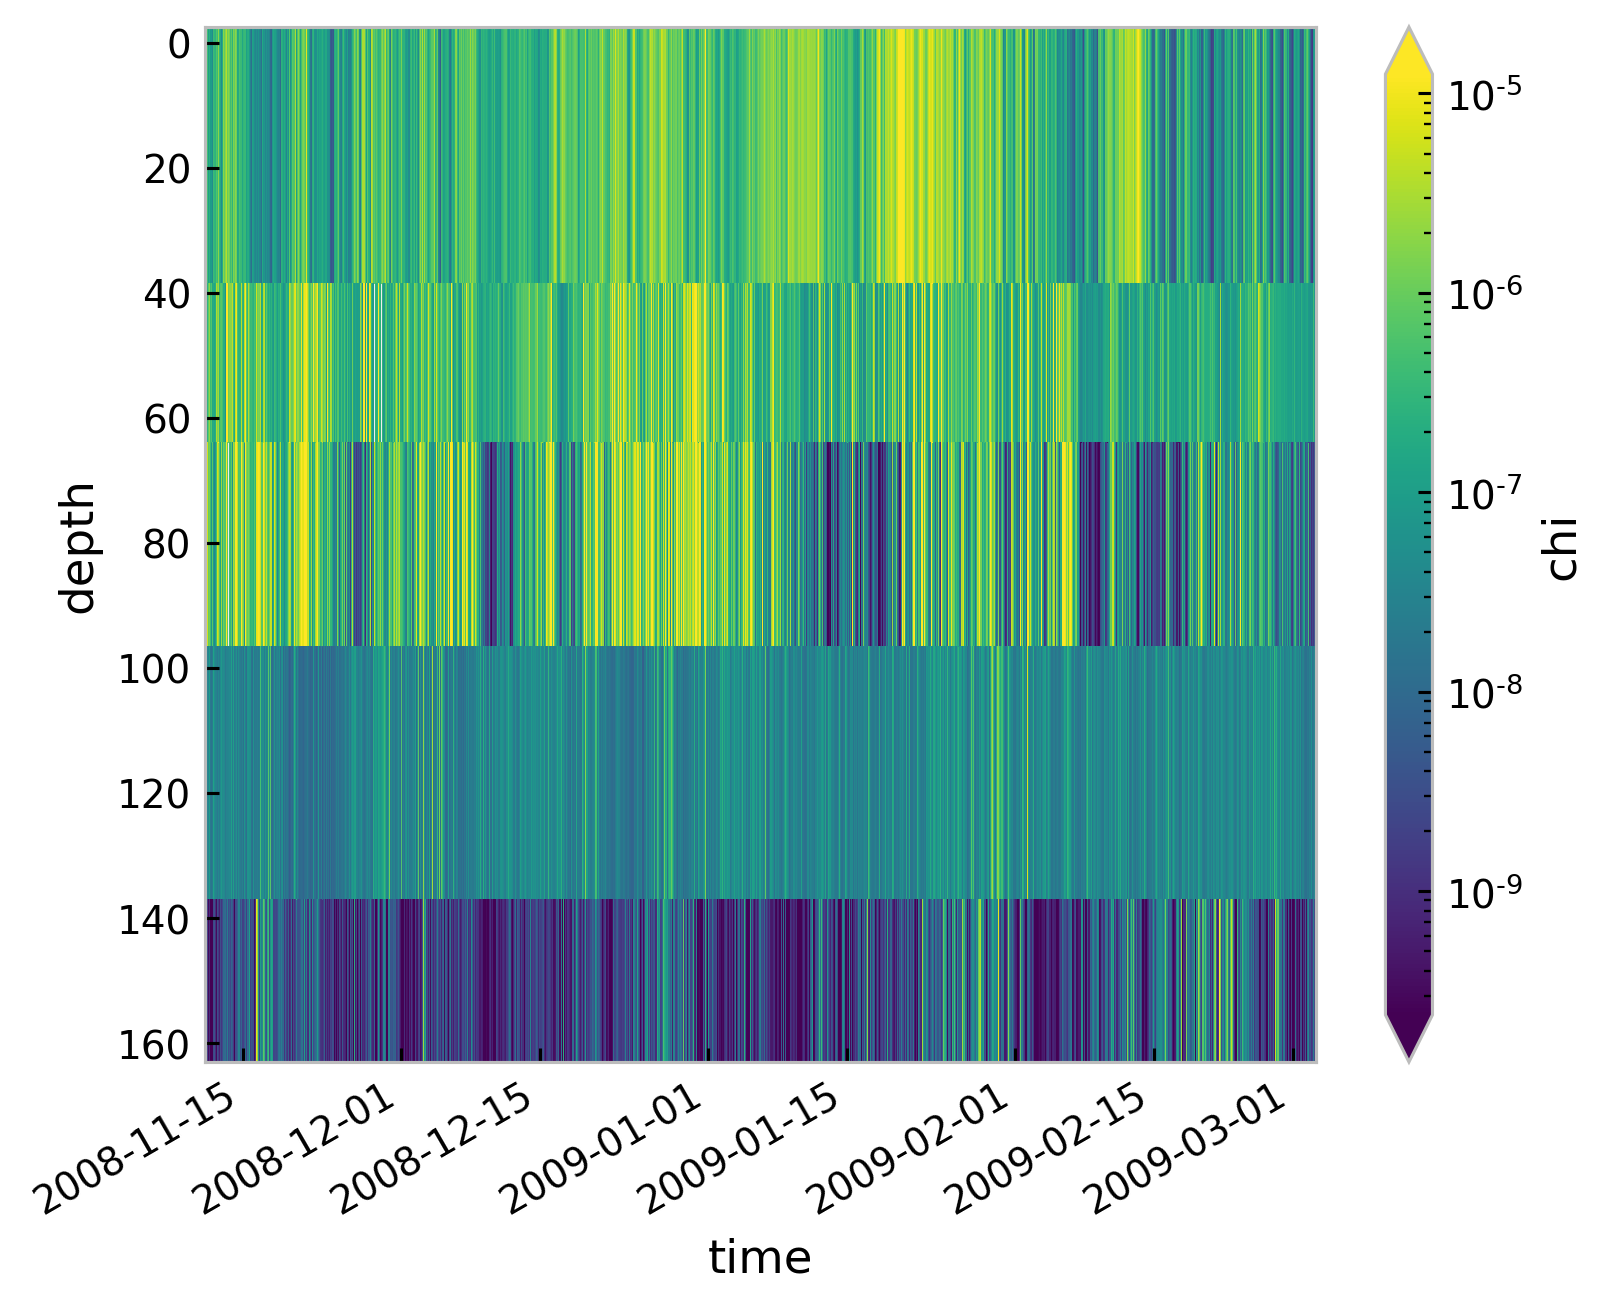

In [43]:
tao.chi.cf.plot(robust=True, norm=mpl.colors.LogNorm())
plt.figure()
tao_eop.chi.cf.plot(robust=True, norm=mpl.colors.LogNorm())